<a href="https://colab.research.google.com/github/tomstocks43/team-project-notebook/blob/master/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet50 for compound/non compound figure classification // Thomas Stocks

## Use the Below Cell to link this notebook to the google drive of "industrialprojectsheffield@gmail.com". Email the team for password.


In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## This code is for creating folders for each class and sorting the images into said classes.

In [1]:
#importing images and seperating labels into respective folders
import json
import sys
import os
from tqdm import tqdm
from shutil import copyfile

if os.path.isdir("drive/My Drive/Data/compound_figure") and os.path.isdir("drive/My Drive/Data/non_compound_figure"):
  sys.exit('The 2 class subfolders already exist. Exiting...')

path2json = 'drive/My Drive/d1_compound_not_compound/'
rootdir = 'drive/My Drive/'
newdatadir = rootdir + 'Data/'

try:
  os.mkdir(rootdir + 'Data')
  os.mkdir(newdatadir + 'compound_figure')
  os.mkdir(newdatadir + 'non_compound_figure')
except:
  pass


with open(path2json+'labels.json') as label_file: 
  data = json.load(label_file)
  for i in tqdm(range(len(data))):
    fname = data[i]['filename']
    label = data[i]['label']
    dst = newdatadir+label+r'/'+fname
       
    copyfile(path2json + fname, dst)
  


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


##  This code sets up the data input stream and importing the model from keras

In [9]:
from keras.applications.resnet50 import ResNet50, preprocess_input

HEIGHT = 300
WIDTH = 300

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "drive/My Drive/Data"
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True,
      validation_split=0.1
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    subset='training')

val_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                    subset='validation')

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## This code assembles the model as previously, we removed the output layers of ResNet so we need to add our own output layers

### NB we also set the imported layers from ResNet as untrainable. 

In [0]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model


def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model
  
class_list = ['compound_figure', 'non_compound_figure']
FC_LAYERS = [1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))


# Now we can fit the last layers to the data
## Go to Edit -> Notebook Settings - > Hardware accelaration and select GPU for much quicker train time

In [0]:
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint

NUM_EPOCHS = 10
BATCH_SIZE = 8
num_train_images = 2000

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

filepath="drive/My Drive" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator, 
                                       epochs=NUM_EPOCHS, 
                                       workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, 
                                       validation_data = val_generator,
                                       validation_steps = val_generator.samples // BATCH_SIZE
                                      )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
250/250 [==============================] - 195s 780ms/step - loss: 1.2533 - acc: 0.6860 - val_loss: 0.8663 - val_acc: 0.7000
Epoch 2/10
250/250 [==============================] - 99s 397ms/step - loss: 0.7266 - acc: 0.7610 - val_loss: 1.0577 - val_acc: 0.6300
Epoch 3/10
250/250 [==============================] - 99s 396ms/step - loss: 0.5846 - acc: 0.7670 - val_loss: 0.5847 - val_acc: 0.7500
Epoch 4/10
250/250 [==============================] - 99s 396ms/step - loss: 0.4806 - acc: 0.7825 - val_loss: 0.5489 - val_acc: 0.7600
Epoch 5/10
250/250 [==============================] - 99s 397ms/step - loss: 0.4360 - acc: 0.8030 - val_loss: 0.6216 - val_acc: 0.7050
Epoch 6/10
250/250 [==============================] - 99s 397ms/step - loss: 0.4174 - acc: 0.8185 - val_loss: 0.6611 - val_acc: 0.7100
Epoch 7/10
250/250 [==============================] - 99s 397ms/step - loss: 0.4389 - acc: 0.8085 - val_loss: 0.5042 - val_acc: 0.7400
Epoch 

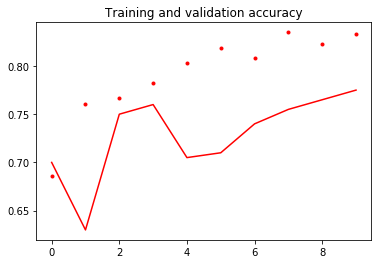

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')

plot_training(history)

['/job:localhost/replica:0/task:0/device:GPU:0']